In [13]:
import cropper
import dm_den
import dm_den_viz
import paths
import copy
import numpy as np
from UCI_tools import staudt_tools
from staudt_utils import mprint
from adjustText import adjust_text
from progressbar import ProgressBar

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib import rcParams

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=14

In [11]:
df = dm_den.load_data('dm_stats_20220715.h5')
dfcut = df.drop(['m12w','m12z'])

# Ellipsoids

In [24]:
ptype = 'PartType0'
galnames = df.index

def plt_ellipsoids(ptype, xlim=(None, None), ylim=(None, None), 
                   figsize=(10*0.91,7*0.9), xcol='v_dot_rhat',
                   xcoord='r', ycol='v_dot_phihat'):
    fig,axs = plt.subplots(3, 5, figsize=figsize, sharey='row', sharex='col',
                           dpi=120)
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    if ycol=='v_dot_phihat':
        axs[1,0].set_ylabel('$v_\\phi\ \\left[\mathrm{km\,s^{-1}}\\right]$')
    elif ycol=='v_dot_zhat':
        axs[1,0].set_ylabel('$v_z\ \\left[\mathrm{km\,s^{-1}}\\right]$')
    axs[2,2].set_xlabel('$v_\mathrm{{{0:s}}}\ '
                        '\\left[\mathrm{{km\,s^{{-1}}}}\\right]$'\
                        .format(xcoord))
    axs = axs.ravel()    
    
    pbar = ProgressBar()
    for i, galname in enumerate(pbar(galnames)):
        gal = cropper.load_data(galname, getparts=[ptype], verbose=False)
        rs = gal[ptype]['r']
        inshell = np.abs(rs-8.3) < df.attrs['dr']/2.
        indisc = np.abs(gal[ptype]['coord_rot'][:,2]) < df.attrs['dz']/2.
        try:
            Tcool = 1.e4
            iscool = gal[ptype]['T'] < Tcool
        except:
            iscool = np.repeat(True,len(indisc))
            Tcool = None

        axs[i].grid(False)
        axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
                  gal[ptype][ycol][inshell&indisc&iscool],
                  bins=int(70), density=True, norm=mpl.colors.LogNorm(), 
                  cmap='viridis')
        axs[i].set_facecolor(plt.cm.viridis(0))
        
        axs[i].set_xlim(*xlim)
        axs[i].set_ylim(*ylim)
        axs[i].set_aspect(1)
        axs[i].tick_params(axis='both', labelsize=7)
        
        axs[i].annotate(galname,
                (0.04, 0.96),
                xycoords='axes fraction', fontsize=13,
                horizontalalignment='left',
                verticalalignment='top',
                color='white')
    axs[-1].remove()
    if Tcool:
        Ttxt = '\n$T<{0:s}\,\mathrm{{K}}$'.format(mprint(Tcool,
                                                         d=0,
                                                         show=False)\
                                                  .replace('$',''))
    else:
        Ttxt = ''
    axs[-2].annotate('$r=8.3\pm{0:0.2f}\,\mathrm{{kpc}}$\n'
                     '$|z|\leq{1:0.2f}\,\mathrm{{kpc}}$'
                     '{2:s}'.format(df.attrs['dr']/2.,
                                    df.attrs['dz']/2.,
                                    Ttxt),
                    (1.05, 0.9),
                xycoords='axes fraction', fontsize=10,
                horizontalalignment='left',
                verticalalignment='top')
    plt.show()
    return None

100% |########################################################################|


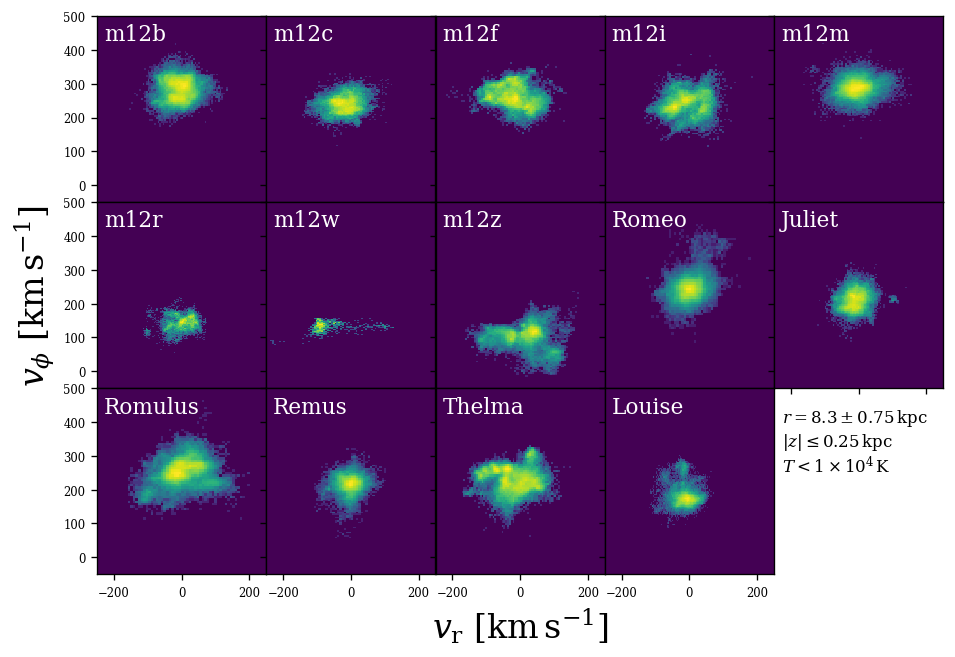

In [25]:
plt_ellipsoids('PartType0', xlim=(-250,250), ylim=(-50,500),
               figsize=(10*0.91,7*0.88))

<ipython-input-4-935fb00ae6f6>:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
100% |########################################################################|


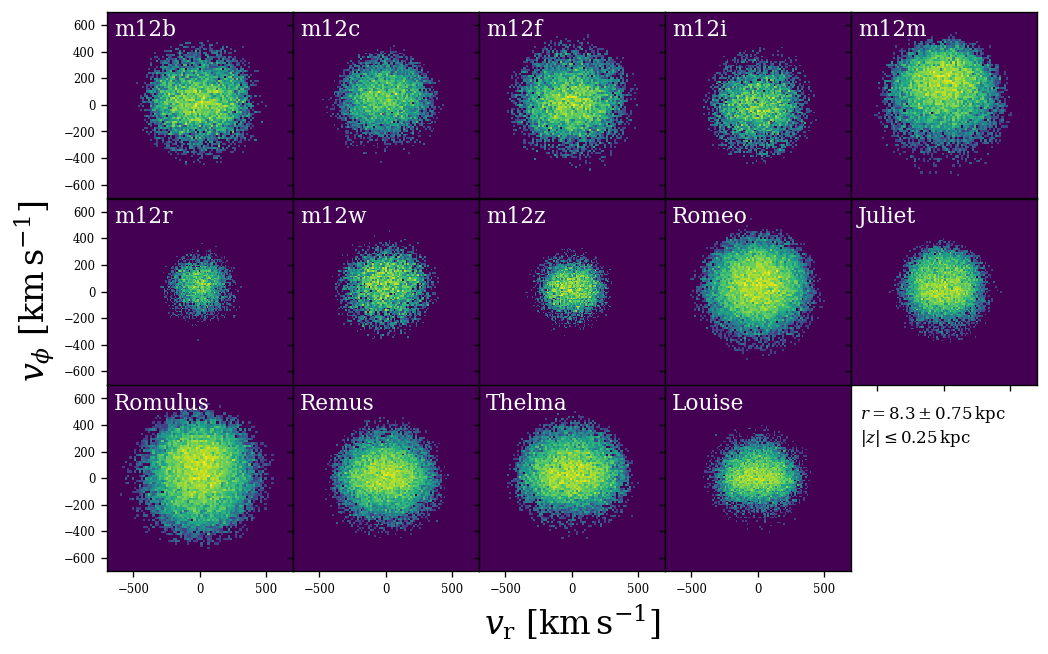

In [6]:
plt_ellipsoids('PartType1', xlim=(-700, 700), ylim=(-700, 700), 
               figsize=(10,6*1.03))

<ipython-input-4-935fb00ae6f6>:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
100% |########################################################################|


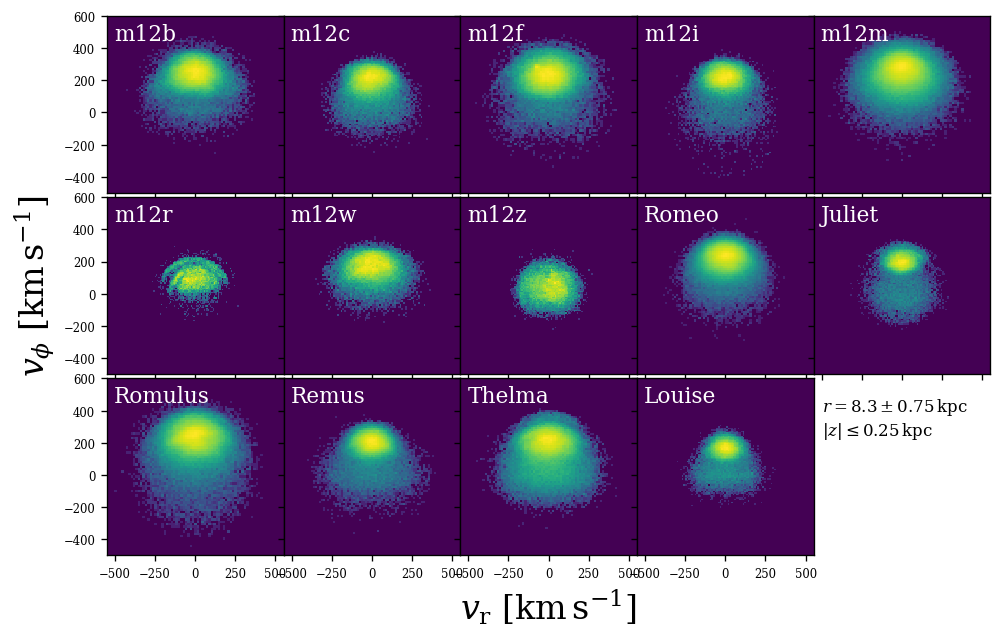

In [7]:
plt_ellipsoids('PartType4', xlim=(-550, 550), ylim=(-500, 600),
               figsize=(10*0.95,6))

In [8]:
def plt_ellipsoids_vs_vz(ptype):
    for galname in galnames:
        gal = cropper.load_data(galname, getparts=[ptype])
        rs = gal[ptype]['r']
        inshell = np.abs(rs-8.3) < 1.5/2.
        indisc = np.abs(gal[ptype]['coord_rot'][:,2])<0.25
        try:
            iscool = gal[ptype]['T'] < 1.e4
        except:
            iscool = np.repeat(True,len(indisc))

        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111)
        ax.hist2d(gal[ptype]['v_dot_zhat'][inshell&indisc&iscool],
                  gal[ptype]['v_dot_phihat'][inshell&indisc&iscool],
                  bins=int(70), density=True, norm=mpl.colors.LogNorm(), 
                  cmap='viridis')
        ax.set_facecolor(plt.cm.viridis(0))
        ax.set_ylabel('$v_\\phi\ \\left[\mathrm{km\,s^{-1}}\\right]$')
        ax.set_xlabel('$v_\mathrm{z}\ \\left[\mathrm{km\,s^{-1}}\\right]$')
        #ax.set_ylim(100, 400)
        ax.set_aspect(1)
        plt.show()
    return None

<ipython-input-4-935fb00ae6f6>:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
100% |########################################################################|


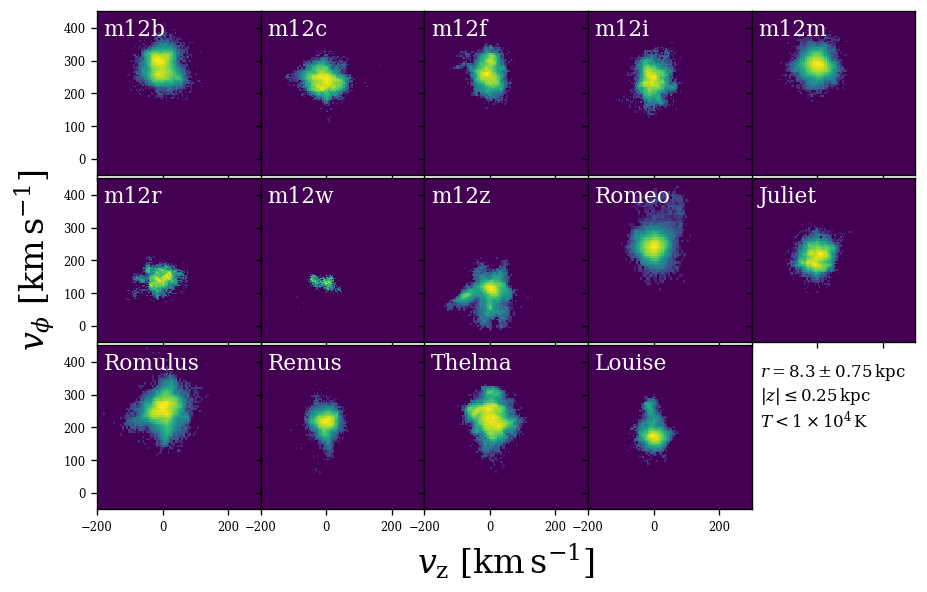

In [9]:
plt_ellipsoids('PartType0', xcol='v_dot_zhat',
               xcoord='z', ylim=(-50,450), xlim=(-200,300),
               figsize=(8*1.1,7*0.79))

<ipython-input-4-935fb00ae6f6>:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
100% |########################################################################|


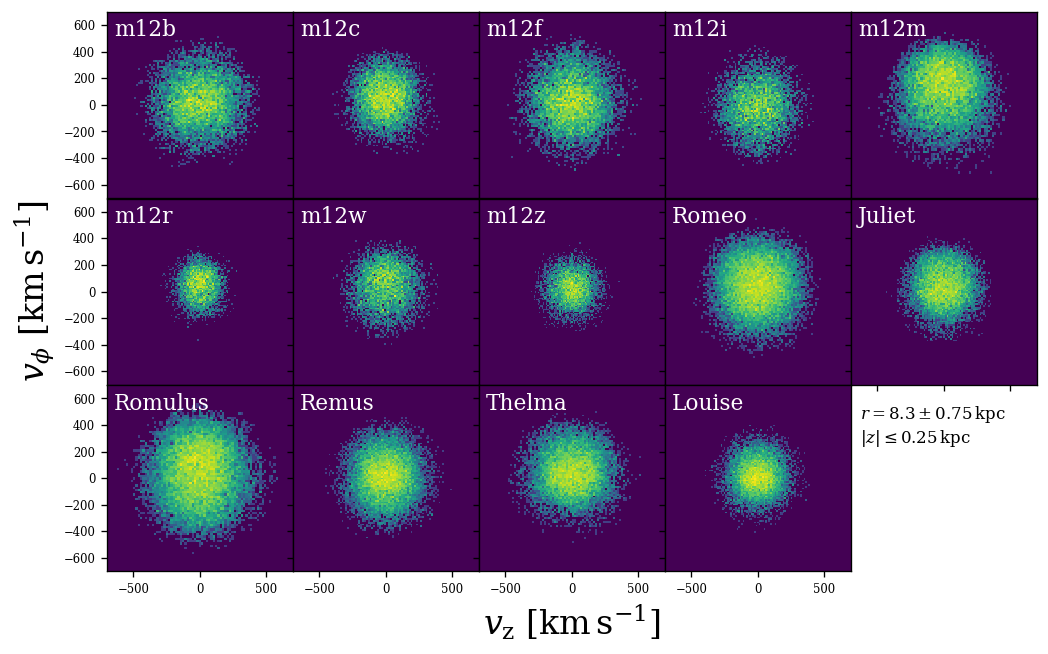

In [10]:
plt_ellipsoids('PartType1', xcol='v_dot_zhat',
               xcoord='z', xlim=(-700, 700), ylim=(-700, 700), 
               figsize=(10,6*1.03))

<ipython-input-4-935fb00ae6f6>:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
100% |########################################################################|


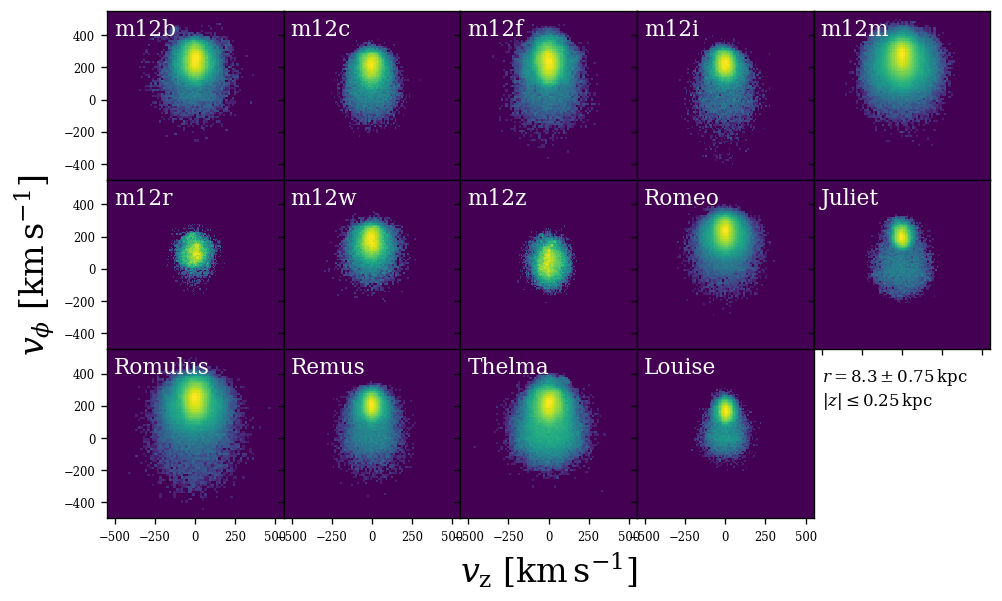

In [11]:
plt_ellipsoids('PartType4', xcol='v_dot_zhat',
               xcoord='z', ylim=(-500,550), xlim=(-550,550),
               figsize=(10*.95,7*0.8))

In [12]:
from importlib import reload
reload(cropper)

<module 'cropper' from '/nfspool-0/home/pstaudt/projects/project01/cropper.py'>

<ipython-input-4-935fb00ae6f6>:33: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  axs[i].hist2d(gal[ptype][xcol][inshell&indisc&iscool],
100% |########################################################################|


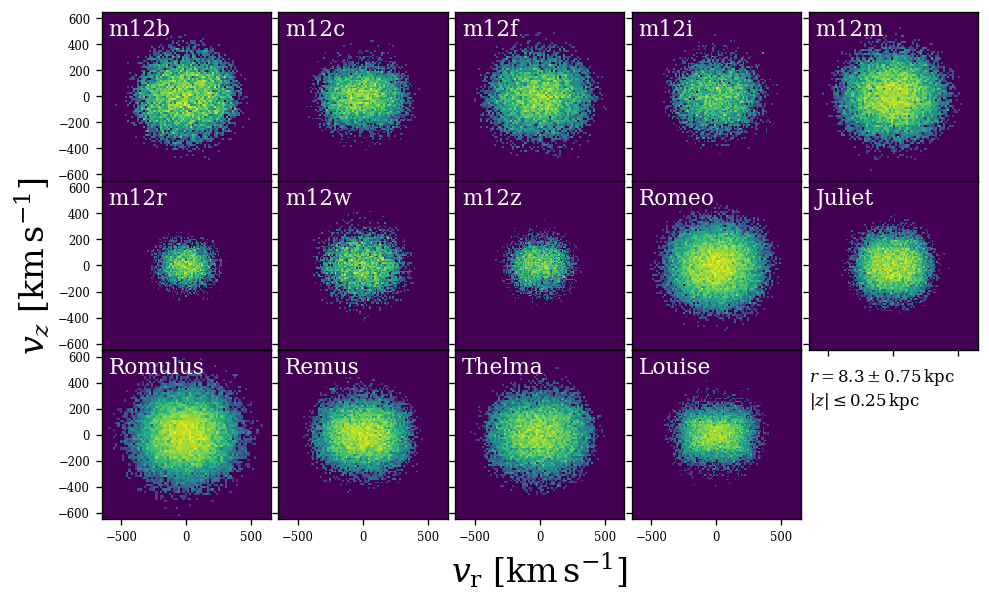

In [13]:
plt_ellipsoids('PartType1', ycol='v_dot_zhat', xcol='v_dot_rhat',
               xcoord='r', ylim=(-650,650), xlim=(-650,650),
               figsize=(10*.95,7*0.8))

# Quantification

In [14]:
'''df = dm_den.load_data('dm_stats_20220629.h5')
for galname in df.index:
    gal = cropper.load_data(galname, getparts=['PartType1'])['PartType1']
    inshell = np.abs(gal['r'] - 8.3)<=df.attrs['dr']/2.
    indisc = np.abs(gal['coord_rot'][:,2])<=df.attrs['dz']/2.
    df.loc[galname,
           'std(v_dot_zhat_disc(dm))'] = np.std(gal['v_dot_zhat']\
                                                       [inshell
                                                        &indisc])
    df.loc[galname,
           'std(v_dot_rhat_disc(dm))'] = np.std(gal['v_dot_rhat']\
                                                       [inshell
                                                        &indisc])
    df.loc[galname,
           'std(v_dot_phihat_disc(dm))'] = np.std(gal['v_dot_phihat']\
                                                       [inshell
                                                        &indisc])
dm_den.save_data(df, 'dm_stats_20220715.h5')'''

"df = dm_den.load_data('dm_stats_20220629.h5')\nfor galname in df.index:\n    gal = cropper.load_data(galname, getparts=['PartType1'])['PartType1']\n    inshell = np.abs(gal['r'] - 8.3)<=df.attrs['dr']/2.\n    indisc = np.abs(gal['coord_rot'][:,2])<=df.attrs['dz']/2.\n    df.loc[galname,\n           'std(v_dot_zhat_disc(dm))'] = np.std(gal['v_dot_zhat']                                                       [inshell\n                                                        &indisc])\n    df.loc[galname,\n           'std(v_dot_rhat_disc(dm))'] = np.std(gal['v_dot_rhat']                                                       [inshell\n                                                        &indisc])\n    df.loc[galname,\n           'std(v_dot_phihat_disc(dm))'] = np.std(gal['v_dot_phihat']                                                       [inshell\n                                                        &indisc])\ndm_den.save_data(df, 'dm_stats_20220715.h5')"

## Plotting raw values

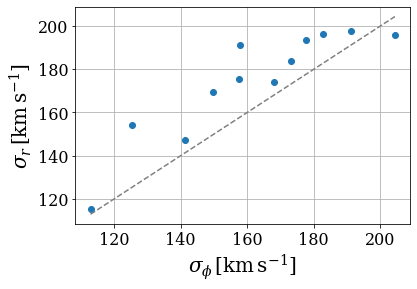

In [6]:
ys = dfcut['std(v_dot_rhat_disc(dm))']
xs = dfcut['std(v_dot_phihat_disc(dm))']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs,
        ys,
        'o')
ax.plot([xs.min(),xs.max()],[xs.min(),xs.max()],color='gray',ls='--')
ax.set_xlabel('$\sigma_\phi\,\mathrm{\\left[km\,s^{-1}\\right]}$')
ax.set_ylabel('$\sigma_r\,\mathrm{\\left[km\,s^{-1}\\right]}$')
plt.show()

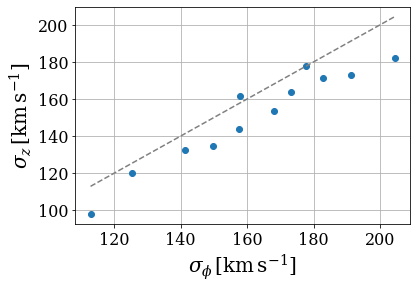

In [7]:
xs = dfcut['std(v_dot_phihat_disc(dm))']
ys = dfcut['std(v_dot_zhat_disc(dm))']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xs,
        ys,
        'o')
ax.plot([xs.min(),xs.max()],[xs.min(),xs.max()],color='gray',ls='--')
ax.set_ylabel('$\sigma_z\,\mathrm{\\left[km\,s^{-1}\\right]}$')
ax.set_xlabel('$\sigma_\phi\,\mathrm{\\left[km\,s^{-1}\\right]}$')
plt.show()

## Plotting ratios

In [8]:
def plt_ratios(xcol, xlabel, expand_points1=(1.05,1.2), 
               expand_points2=(1.05,1.2)):
    def add_labels(ax, xs, ys, **kwargs):
        texts=[] #make a container for labels that adjust_text will tune           
        for x,y,name in zip(xs, ys, dfcut.index):                                     
            #add annotation to texts                                               
            texts+=[ax.annotate(name, (float(x), float(y)),           
                                fontsize=14)]                               
        adjust_text(texts, arrowprops={'arrowstyle':'-'}, ax=ax,
                    **kwargs)
        return None

    xs = dfcut[xcol]
    
    fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True,
                            dpi=105)
    axs = axs.ravel()
    #fig.subplots_adjust(wspace=0.05, hspace=0.0)

    ys_z = dfcut['std(v_dot_zhat_disc(dm))']/dfcut['std(v_dot_phihat_disc(dm))']
    axs[0].plot(xs,
                ys_z,
                'o')
    #ax.plot([xs.min(),xs.max()],[xs.min(),xs.max()],color='gray',ls='--')
    axs[0].set_ylabel('$\sigma_z/\sigma_\phi$')
    axs[0].set_xlabel(xlabel)


    ys_r = dfcut['std(v_dot_rhat_disc(dm))']/dfcut['std(v_dot_phihat_disc(dm))']
    axs[1].plot(xs,
                ys_r,
                'o')
    #ax.plot([xs.min(),xs.max()],[xs.min(),xs.max()],color='gray',ls='--')
    axs[1].set_ylabel('$\sigma_r/\sigma_\phi$')
    axs[1].set_xlabel(xlabel)
    #add_labels(axs[1], xs, ys)          

    add_labels(axs[0], xs, ys_z, expand_points=expand_points1)   
    add_labels(axs[1], xs, ys_r, expand_points=expand_points2) 

    plt.show()
    
    return None

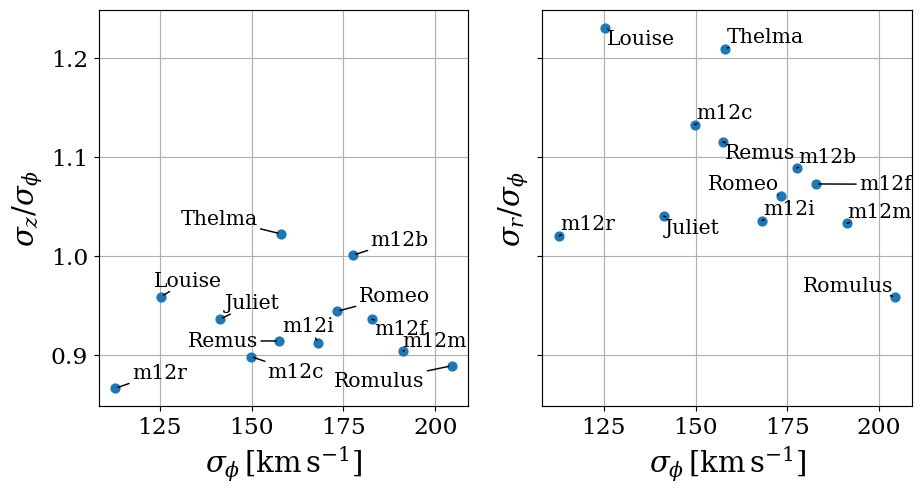

In [9]:
plt_ratios('std(v_dot_phihat_disc(dm))', 
           '$\sigma_\phi\,\mathrm{\\left[km\,s^{-1}\\right]}$',
           expand_points1=(1.6,1.6))

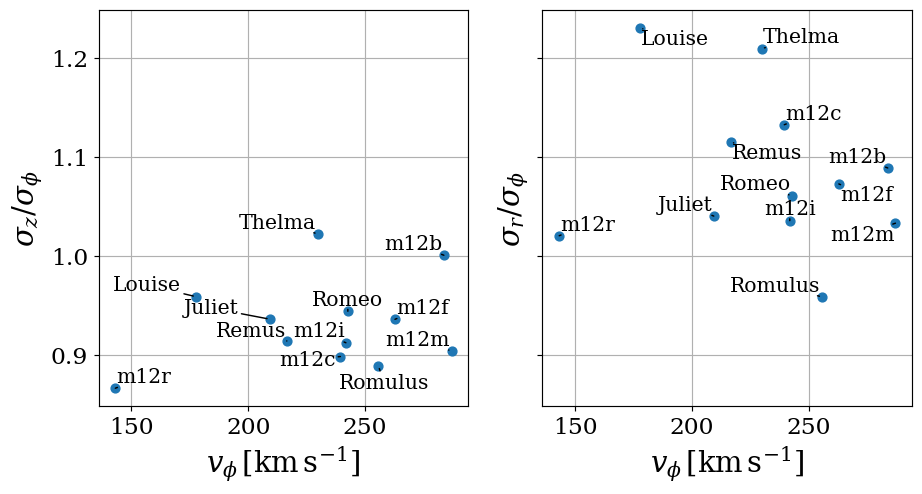

In [10]:
plt_ratios('v_dot_phihat_disc(T<=1e4)', 
           '$v_\phi\,\mathrm{\\left[km\,s^{-1}\\right]}$')

## Column plots

$\beta = 1 - \dfrac{\sigma_\phi^2+\sigma_z^2}{2\sigma_r^2}$  

$\beta_\phi = 1 - \dfrac{\sigma_\phi^2}{\sigma_r^2}$  

$\beta_z = 1 - \dfrac{\sigma_z^2}{\sigma_r^2}$

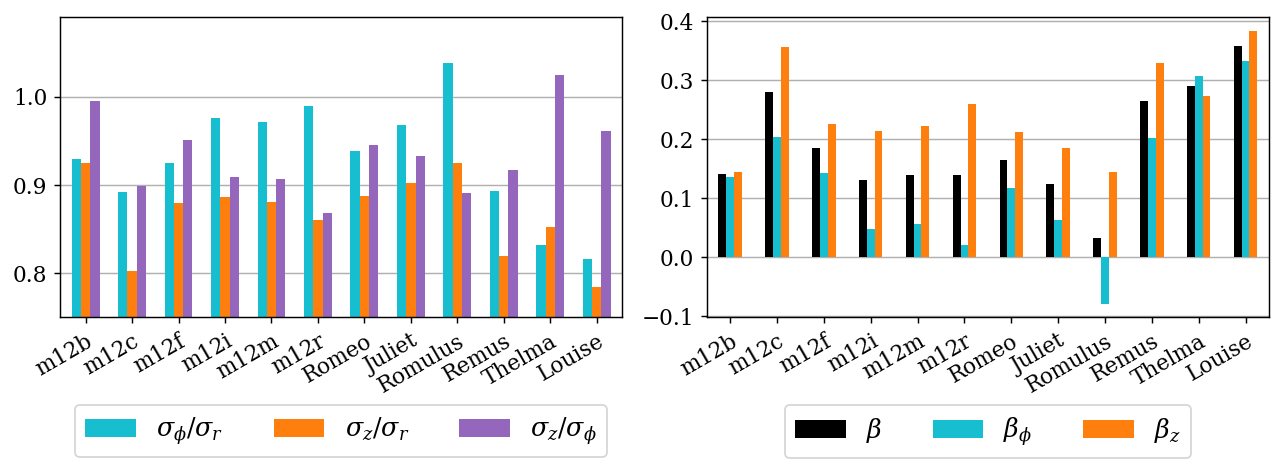

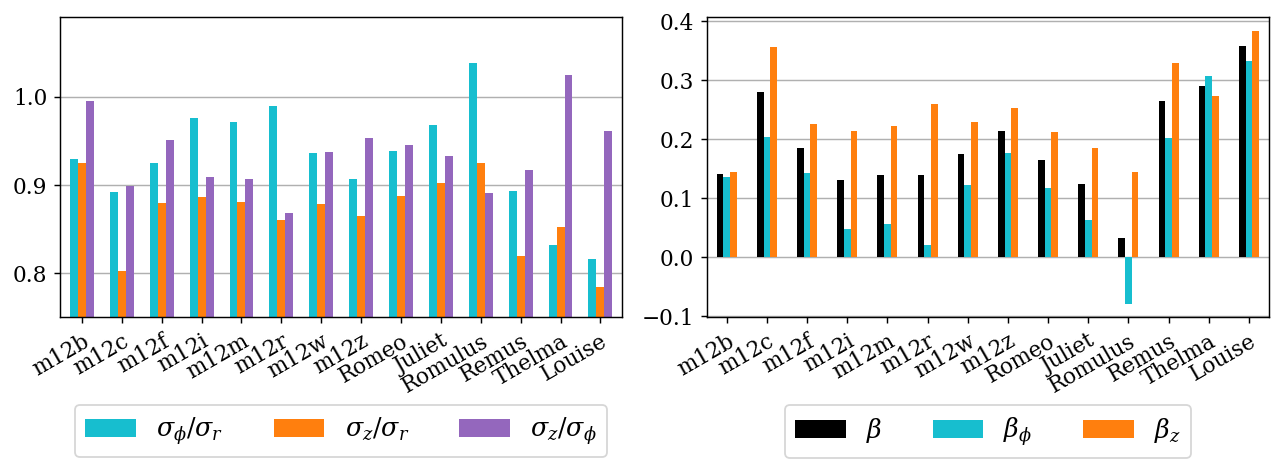

In [20]:
dm_den_viz.plt_anisotropy('dm_stats_dz1.0_20231211.h5')
dm_den_viz.plt_anisotropy('dm_stats_dz1.0_20231211.h5', only_discs=False)

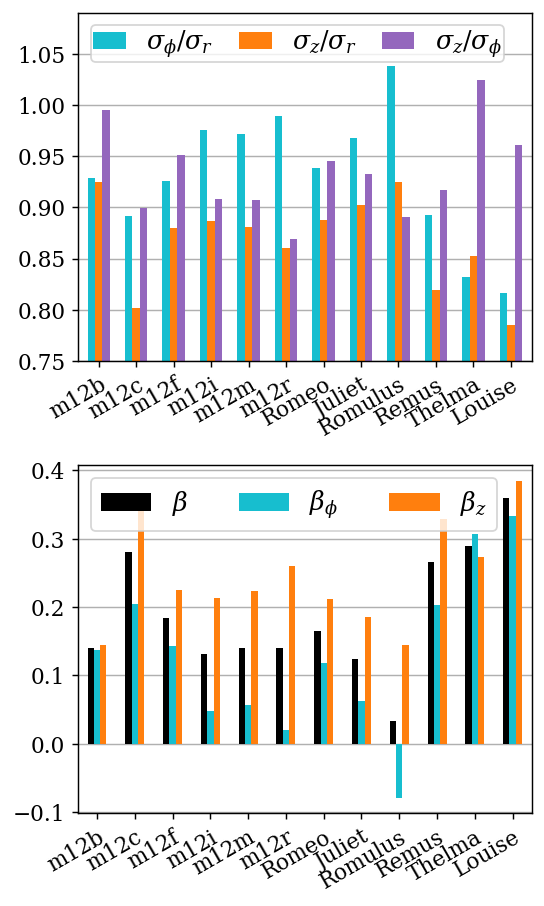

In [25]:
reload(dm_den_viz)
dm_den_viz.plt_anisotropy('dm_stats_dz1.0_20231211.h5', vertical=True)